## Intensity filtered data using reference aluminium wavelength 309.506 (pixel number 445) using saturated data

### No preprocessing

In [1]:
import os
from sys import stdout
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peakutils
%matplotlib inline 
from math import sqrt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.linear_model import ElasticNet,ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
    mse = []
    component = np.arange(1, n_comp)
    for i in component:
        pls = PLSRegression(n_components=i)
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
        mse.append(mean_squared_error(y, y_cv))
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
        plt.show()
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
    
    return
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
"""   
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Brix')
        plt.ylabel('Measured $^{\circ}$Brix')
        plt.show()
    return
""" 

"   \n    # Fit a line to the CV vs response\n    z = np.polyfit(y, y_c, 1)\n    with plt.style.context(('ggplot')):\n        fig, ax = plt.subplots(figsize=(9, 5))\n        ax.scatter(y_c, y, c='red', edgecolors='k')\n        #Plot the best fit line\n        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)\n        #Plot the ideal 1:1 line\n        ax.plot(y, y, color='green', linewidth=1)\n        plt.title('$R^{2}$ (CV): '+str(score_cv))\n        plt.xlabel('Predicted $^{\\circ}$Brix')\n        plt.ylabel('Measured $^{\\circ}$Brix')\n        plt.show()\n    return\n"

In [3]:
def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
    Xc = X[:,sorted_ind]
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [4]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

In [5]:
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        data_snv[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    return data_snv

In [6]:
x_df = pd.read_csv('../avg_base_wl_norm_24-02.csv', sep = ',')
values = x_df.values
#wl=x_df.columns.values
#print(wl.shape)

#print(values)
#print(type(values))
print(values.shape)
print(values[1].shape)
print(len(values))
x_df

(24, 1446)
(1446,)
24


,252.071400,252.201700,252.331900,252.462200,252.592400,252.722600,252.852900,252.983100,253.113300,253.243600,...,428.718100,428.828600,428.939000,429.049500,429.159900,429.270300,429.380600,429.491000,429.601300,429.711600
0,-0.000051,-0.000137,-0.000348,0.000134,-0.000060,-0.000077,0.000103,0.000288,0.000048,-0.000200,...,0.000521,0.001721,0.004923,0.003764,0.001069,0.000188,-0.000245,-0.000420,-0.000480,-0.000328
1,-0.001003,-0.000983,-0.001484,-0.000547,-0.000816,-0.001066,-0.000582,-0.000177,-0.000701,-0.001171,...,0.000279,-0.000513,-0.000753,-0.000850,-0.000457,-0.000360,-0.001016,-0.001207,-0.001517,-0.001294
2,-0.000341,-0.000526,-0.000959,-0.000165,-0.000454,-0.000580,-0.000363,0.000072,-0.000358,-0.000667,...,0.000353,-0.000297,-0.000363,-0.000443,-0.000008,-0.000071,-0.000568,-0.000726,-0.000842,-0.000741
3,-0.000568,-0.000668,-0.001076,-0.000203,-0.000601,-0.000808,-0.000456,-0.000069,-0.000465,-0.000773,...,0.000238,-0.000381,-0.000311,-0.000482,-0.000088,-0.000271,-0.000807,-0.001016,-0.001190,-0.000999
4,0.000615,0.000247,0.000025,0.000840,0.000589,0.000853,0.001643,0.001616,0.000699,-0.000022,...,0.000197,-0.000316,-0.000706,-0.000500,-0.000089,-0.000213,-0.000574,-0.000726,-0.000858,-0.000666
5,0.000623,0.000112,-0.000077,0.000916,0.000636,0.000809,0.001711,0.001559,0.000529,-0.000098,...,0.000244,-0.000184,-0.000098,-0.000164,-0.000065,-0.000170,-0.000652,-0.000780,-0.000873,-0.000697
6,-0.000550,-0.000641,-0.001207,-0.000107,-0.000427,-0.000747,-0.000301,-0.000033,-0.000588,-0.001100,...,0.000613,-0.000350,-0.000590,-0.000545,-0.000060,-0.000018,-0.000693,-0.000959,-0.001114,-0.000919
7,-0.000210,-0.000352,-0.000602,0.000056,-0.000297,-0.000301,-0.000004,0.000193,-0.000140,-0.000479,...,0.000458,-0.000105,-0.000136,-0.000052,0.000116,0.000011,-0.000311,-0.000540,-0.000697,-0.000556
8,0.000343,0.000048,-0.000111,0.000531,0.000399,0.000530,0.001000,0.001059,0.000538,0.000049,...,0.000453,0.000015,-0.000034,-0.000083,0.000113,0.000099,-0.000159,-0.000174,-0.000329,-0.000161
9,0.000985,0.000507,0.000423,0.001340,0.001131,0.001475,0.002382,0.002284,0.001182,0.000585,...,0.000317,-0.000102,-0.000244,-0.000240,0.000014,0.000034,-0.000183,-0.000354,-0.000428,-0.000289


[252.0714 252.2017 252.3319 ... 429.491  429.6013 429.7116]


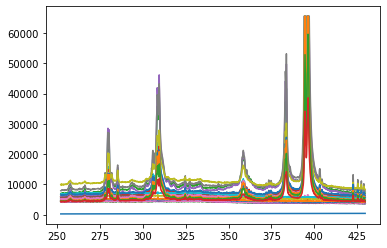

In [7]:
#This is just for visualizing the various plots of the samples

df = pd.read_csv('../ref_new/1.csv')
data=df.values
wl= data[0]
print(wl)

for i in range(len(values)):
    plt.plot(wl, data[i,:])
    #plt.show() #comment this one to have unique plot instead of multiple ones
#range(len(dfs))
#"""



In [8]:
df_y = pd.read_csv('../concentration_1.csv', sep = ',')
print(type(df_y))
concentration=df_y.values
print(concentration.shape)
#print(concentration)

y_values=df_y.values
y_all=pd.DataFrame(y_values[:,1:-2])
#print(y_all)
df_y

<class 'pandas.core.frame.DataFrame'>
(24, 9)


,Reference Number,Si,Fe,Mg,Zn,Cu,Mn,Al,Total
0,1,0.185,0.228,2.940,0.0304,0.0620,0.280,96.0000,99.7254
1,2,0.360,0.600,1.100,0.0700,0.2000,0.830,96.5787,99.7387
2,3,9.140,1.010,0.200,0.4200,3.6000,0.410,84.7770,99.5570
3,4,8.565,0.000,0.293,0.8870,2.6360,0.330,86.5650,99.2760
4,5,9.500,0.000,0.391,0.0000,0.0580,0.016,90.0210,99.9860
5,6,7.220,0.140,0.360,0.0840,0.1200,0.053,91.8090,99.7860
6,7,7.460,0.530,0.036,0.1400,0.1500,0.100,91.4140,99.8300
7,8,12.900,0.120,0.520,0.1550,0.5200,0.286,84.7905,99.2915
8,9,8.750,0.460,1.710,0.0290,2.0000,0.056,85.3100,98.3150
9,10,0.260,0.420,1.260,0.0200,0.0040,1.160,96.8346,99.9586


In [9]:
y_val = concentration[:,1] #1-Si, 2-Fe, 3-Mg, 5-Cu, 6-Mn (4-Zn but too much sparse)
print(y_val)
print(y_val.shape)
y_df= pd.DataFrame(y_val)
#y_df

[ 0.185  0.36   9.14   8.565  9.5    7.22   7.46  12.9    8.75   0.26
  0.07   0.16   6.12  12.53   0.53   0.16   3.     9.46   0.53   9.19
  6.16   0.18   0.18   0.18 ]
(24,)


### Wavelength subset selection

For Silicon (Si) the peaks are at **251.59, 288.12, 390.60**

For Magnesium (Mg) the peaks are at **277.91, 279.59, 280.23, 281.78, 383.74, 285.27**

In [180]:
print(wl.T)
print(wl.shape)
#print(len(wl))
#print(wl[-1])

[252.0714 252.2017 252.3319 ... 429.491  429.6013 429.7116]
(1446,)


In [105]:
#target = [251.59, 288.12, 390.60] #peaks for Si
target = [277.91, 279.59, 280.23, 281.78, 383.74, 285.27] #peaks for Mg
target

[277.91, 279.59, 280.23, 281.78, 383.74, 285.27]

In [108]:
a = []
b = []
for t in target:
    for i in range(len(wl)):
        if abs(wl[i]-t) < 1:
            a.append(wl[i])
            b.append(i)
            
print("number of selected wavelengths: ",len(a), "\n")
print(a, "\n")
print(b)

number of selected wavelengths:  92 

[277.0022, 277.1316, 277.2609, 277.3903, 277.5196, 277.6489, 277.7783, 277.9076, 278.0369, 278.1662, 278.2955, 278.4248, 278.5541, 278.6834, 278.8127, 278.6834, 278.8127, 278.942, 279.0712, 279.2005, 279.3298, 279.459, 279.5883, 279.7175, 279.8467, 279.976, 280.1052, 280.2344, 280.3636, 280.4928, 279.3298, 279.459, 279.5883, 279.7175, 279.8467, 279.976, 280.1052, 280.2344, 280.3636, 280.4928, 280.622, 280.7512, 280.8804, 281.0096, 281.1387, 280.8804, 281.0096, 281.1387, 281.2679, 281.3971, 281.5262, 281.6554, 281.7845, 281.9136, 282.0428, 282.1719, 282.301, 282.4301, 282.5592, 282.6883, 382.791, 382.9103, 383.0295, 383.1487, 383.2679, 383.387, 383.5062, 383.6253, 383.7444, 383.8635, 383.9826, 384.1016, 384.2207, 384.3397, 384.4587, 384.5777, 384.6966, 284.3659, 284.4949, 284.6239, 284.7529, 284.8819, 285.0109, 285.1398, 285.2688, 285.3977, 285.5267, 285.6556, 285.7846, 285.9135, 286.0424, 286.1713] 

[192, 193, 194, 195, 196, 197, 198, 199, 200, 20

In [109]:
print(values.shape)
print(values[:, b].shape)
x_selecta = pd.DataFrame(values[:, b])
x_selecta

(24, 1446)
(24, 92)


,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
0,0.001245,0.001109,0.001256,0.001990,0.003882,0.006350,0.008185,0.010191,0.009762,0.008167,...,0.010506,0.013071,0.014955,0.012331,0.008294,0.005168,0.003768,0.002416,0.001806,0.001257
1,0.001315,0.000638,0.000466,0.000938,0.002316,0.003404,0.004429,0.005635,0.005356,0.004434,...,0.006814,0.012057,0.012938,0.007730,0.004574,0.002000,0.001654,0.000375,0.000272,-0.000208
2,0.000911,0.000218,0.000123,0.000494,0.001134,0.001626,0.002130,0.002441,0.002210,0.001956,...,0.003643,0.007641,0.008114,0.004137,0.002399,0.000869,0.000741,-0.000058,-0.000108,-0.000356
3,0.001000,0.000270,0.000181,0.000691,0.001781,0.002593,0.003704,0.004523,0.004104,0.003588,...,0.005636,0.009937,0.011160,0.006688,0.003884,0.001749,0.001133,0.000165,0.000011,-0.000292
4,0.000535,0.000077,0.000002,0.000387,0.001006,0.001566,0.002114,0.002572,0.002346,0.002188,...,0.003801,0.007772,0.008157,0.004416,0.002323,0.000773,0.000578,-0.000155,-0.000120,-0.000334
5,0.000336,-0.000167,-0.000275,-0.000152,0.000164,0.000239,0.000353,0.000095,0.000105,0.000263,...,0.000486,0.001563,0.001746,0.000526,0.000263,-0.000433,-0.000069,-0.000714,-0.000548,-0.000634
6,0.001514,0.000739,0.000798,0.001232,0.002341,0.003208,0.004117,0.004927,0.004772,0.004383,...,0.005752,0.010578,0.011452,0.006373,0.003980,0.001779,0.001839,0.000500,0.000307,0.000196
7,0.002695,0.002495,0.002743,0.003834,0.006161,0.009199,0.011463,0.013660,0.013309,0.011719,...,0.012517,0.014106,0.016610,0.014741,0.010591,0.006889,0.005221,0.003409,0.002662,0.001887
8,0.001018,0.000650,0.000635,0.000998,0.001910,0.002937,0.003735,0.004770,0.004486,0.003857,...,0.005787,0.010395,0.010899,0.006647,0.003858,0.001963,0.001555,0.000674,0.000385,0.000138
9,0.000626,0.000174,0.000126,0.000510,0.001071,0.001711,0.002323,0.002942,0.002755,0.002314,...,0.004166,0.008443,0.008598,0.004591,0.002403,0.001113,0.000797,0.000061,-0.000062,-0.000403


In [110]:
#X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(19, 92) (19, 1)
(5, 92) (5, 1)
       0
14  0.53
22  0.18
20  6.16
16  3.00
21  0.18


# Principal Components Analysis

In [111]:
n_components=15


x = x_df.values
x= x_selecta.values
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

principalComponents = pca.fit_transform(X_std)
print(principalComponents.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
#print(pca.singular_values_)

(24, 92)
(92,)
24
(24, 15)
[91.5  95.63 99.41 99.66 99.77 99.84 99.89 99.93 99.95 99.96 99.97 99.98
 99.98 99.98 99.98]


In [112]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(principalComponents, y_df)
# Calibration
y_c = regr.predict(principalComponents)
# Cross-validation
y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_df, y_c)
score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation

mse_c = mean_squared_error(y_df, y_c)
mse_cv = mean_squared_error(y_df, y_cv)

print(score_c, score_cv)
print(mse_c, mse_cv)

0.7427477672072518 -4.035217648900607
5.189318256398901 101.57092355125498


now using PCA with Linear regression and PLS

In [113]:
n_components=15

x = X_train.values
x_t = X_test.values
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
X_std_test = StandardScaler().fit_transform(x_t)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

x_pc = pca.fit_transform(X_std)
x_test1 = pca.transform(X_std_test)
print(x_pc.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

(19, 92)
(92,)
19
(19, 15)
[90.17 95.25 99.38 99.63 99.76 99.84 99.9  99.95 99.97 99.98 99.99 99.99
 99.99 99.99 99.99]


In [114]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(x_pc, y_train)
# Calibration
y_p = regr.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_p)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_p)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2_pred: ", score_c)
print("MSE: ", mse_c)

R2_pred:  -3.2912135229091213
MSE:  23.25048146128529


37% completed
Suggested number of components:  2



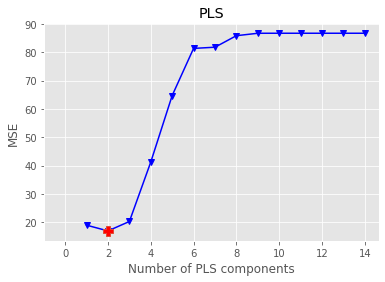

R2 calib: 0.983
R2 CV: 0.217
MSE calib: 0.361
MSE CV: 16.943


In [115]:
optimise_pls_cv(x_pc, y_train, 15, plot_components=True) 

In [116]:
pls = PLSRegression(n_components=3)
# Fit
pls.fit(x_pc, y_train)
# Calibration
y_c = pls.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_c)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_c)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2_pred: ", score_c)
print("MSE: ", mse_c)

R2_pred:  -3.291213522909125
MSE:  23.250481461285307


# Linear Regression
this is ordinary least square regression

R^2_pred:  -7.826182746345193
RMSE:  6.915321417615936 

[real, predictions]
[[ 0.53       11.20581728]
 [ 0.18        5.5188551 ]
 [ 6.16       11.21880146]
 [ 3.          8.88954207]
 [ 0.18        6.20940505]]


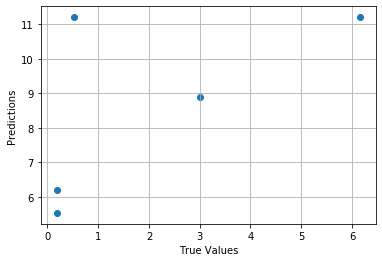

In [117]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)


rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("R^2_pred: ", r2)
print("RMSE: ", rmse, "\n")


b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Partial Least Square Regression

## No preprocessing

In [118]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)
y_test

(19, 92) (19, 1)
(5, 92) (5, 1)


,0
11,0.16
18,0.53
13,12.53
12,6.12
1,0.36


100% completed
Suggested number of components:  1



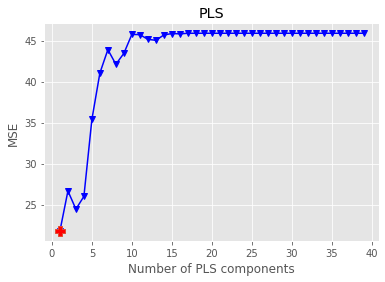

R2 calib: 0.260
R2 CV: -0.080
MSE calib: 14.921
MSE CV: 21.778


In [119]:
optimise_pls_cv(x_df, y_df, 40, plot_components=True)
#optimise_pls_cv(x_df, y_all, 40, plot_components=True)

In [120]:
# Define PLS object
pls = PLSRegression(n_components=3)
# Fit
pls.fit(x_df, y_df)
# Cross-validation
y_cv = cross_val_predict(pls, x_df, y_df, cv=10)
# Calculate scores
score = r2_score(y_df, y_cv)
mse = mean_squared_error(y_df, y_cv)

print("R^2_cv", score)
print("MSE: ", mse)

R^2_cv -0.21138029881074694
MSE:  24.436086839040144


In [121]:
#optimise_pls_cv(X_train,y_train, 40, plot_components=True)

R2_pred:  -1.68270340225193
R2_cv:  -5.776081244352868

TEST
 [real, predictions]
[[ 0.16       14.11021819]
 [ 0.53        3.00407516]
 [12.53        6.38144981]
 [ 6.12        8.34067605]
 [ 0.36        8.79469278]]



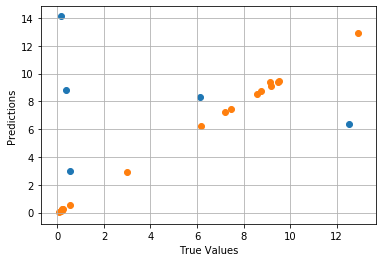

In [122]:
# Define PLS object
pls = PLSRegression(n_components=14)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

In [123]:
print(wl.shape)

(1446,)


## Wavelenght selection for PLS

In [172]:
print("x_selecta shape: ", x_selecta.shape)
start_time = time.time()

#opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_df.values, y_val, 15)
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_selecta.values, y_val, 25)

print("--- %s seconds ---" % (time.time() - start_time))

x_selecta shape:  (24, 92)
100% completed
Optimised number of PLS components:  2
Wavelengths to be discarded  78
Optimised MSEP  22.699822282080618

--- 25.32156991958618 seconds ---


In [163]:
#print(opt_Xc.shape,"\n")
#print("sorted indexes: ", sorted_ind)
print("sorted wavelengths: ", wl[sorted_ind[:10]].T)

#plt.plot(opt_Xc.T)
#plt.show()

sorted wavelengths:  [263.649  252.3319 258.0593 257.669  262.4797 252.4622 258.1893 257.7991
 262.3498 252.2017]


In [173]:
X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 3) #seed for Mg = 3, 16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Si = 7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Cu =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Fe =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 3) #seed for Mn = 3

#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(19, 14) (19, 1)
(5, 14) (5, 1)
       0
22  0.18
12  6.12
17  9.46
15  0.16
14  0.53


7% completed
Suggested number of components:  2



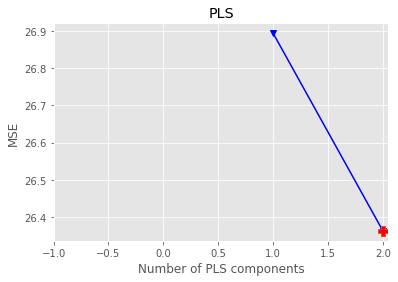

R2 calib: 0.087
R2 CV: -0.257
MSE calib: 19.147
MSE CV: 26.362


In [174]:
optimise_pls_cv(X_train,y_train, 3, plot_components=True)

R2_pred:  -0.023880868311192183
RMSE:  3.8707009546454865

TEST
 [real, predictions]
[[0.18       3.40186831]
 [6.12       5.31047344]
 [9.46       4.66745475]
 [0.16       4.52831157]
 [0.53       5.20174751]]



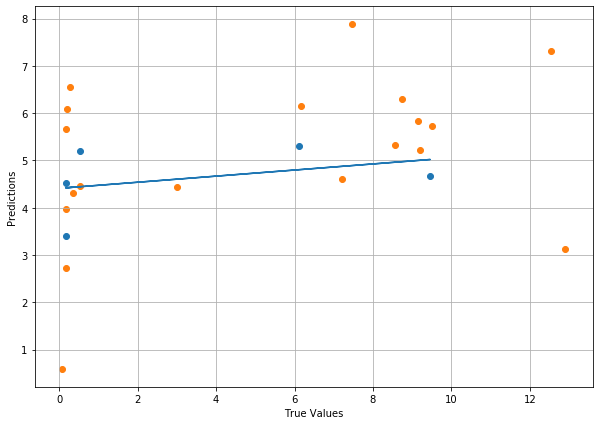

In [175]:
# Define PLS object
pls = PLSRegression(n_components=3)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Normalization

In [176]:
Xn_train = normalize(X_train, axis=1)
Xn_test = normalize(X_test, axis=1)
print(Xn_train.shape)
print(Xn_test.shape)

(19, 14)
(5, 14)


In [177]:
#plt.plot(Xn_train.T)
#plt.show()

In [178]:
#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
#optimise_pls_cv(Xn_train,y_train, 3, plot_components=True)

R2_pred:  -0.6634633050168568
RMSE:  4.933686139866932

TEST
 [real, predictions]
[[0.18       6.06984093]
 [6.12       9.53787273]
 [9.46       3.19529442]
 [0.16       5.6396989 ]
 [0.53       2.99182419]]



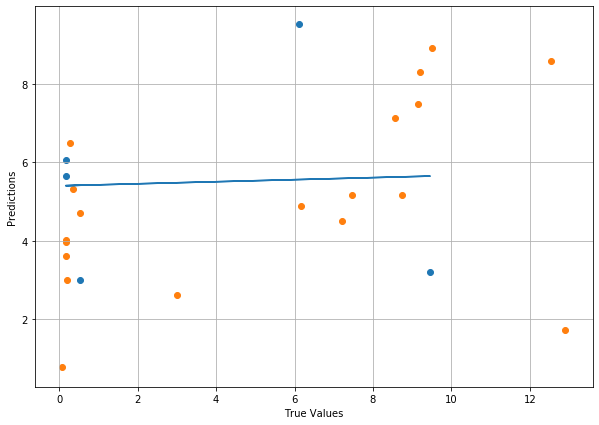

In [179]:
# Define PLS object
pls = PLSRegression(n_components=3)
# Fit
pls.fit(Xn_train, y_train)

y_pred = pls.predict(Xn_test)
y_pred1 = pls.predict(Xn_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using SNV

In [156]:
Xs_train = snv(X_train)
Xs_test = snv(X_test)
print(Xs_train.shape)
print(Xs_test.shape)

#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
#optimise_pls_cv(Xs_train,y_train, 7, plot_components=True)

(19, 14)
(5, 14)


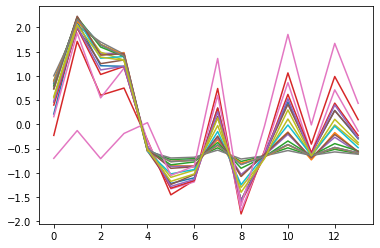

In [157]:
plt.plot(Xs_train.T)
plt.show()

R2_pred:  -0.5158570531065281
RMSE:  5.0966482590899735

TEST
 [real, predictions]
[[ 9.46        7.3764407 ]
 [ 8.565       3.54271484]
 [12.53        6.08675255]
 [ 0.18        7.82073993]
 [ 6.12        6.76668811]]



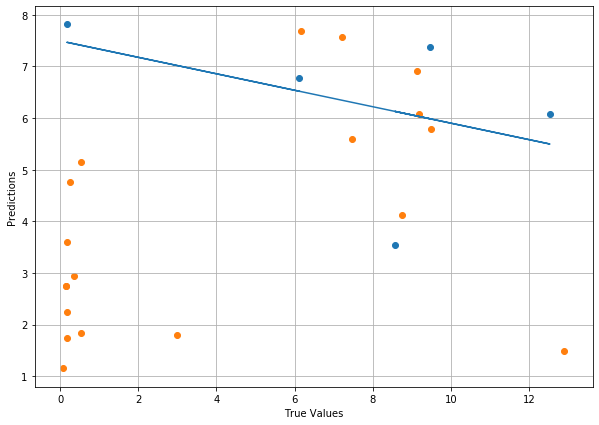

In [158]:
# Define PLS object
pls = PLSRegression(n_components=2)
# Fit
pls.fit(Xs_train, y_train)

y_pred = pls.predict(Xs_test)
y_pred1 = pls.predict(Xs_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Max-norm

In [159]:
Xm_train = X_train / np.max(X_train)
Xm_test = X_test / np.max(X_test)

#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
#optimise_pls_cv(Xm_train,y_train, 7, plot_components=True)

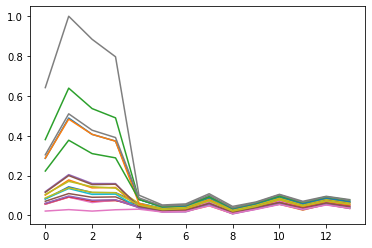

In [160]:
plt.plot(Xm_train.T)
plt.show()

R2_pred:  -9.84703281476486
RMSE:  13.63361465363866

TEST
 [real, predictions]
[[ 9.46       26.39472912]
 [ 8.565      15.81020565]
 [12.53       24.19944912]
 [ 0.18       17.51417172]
 [ 6.12       18.50747898]]



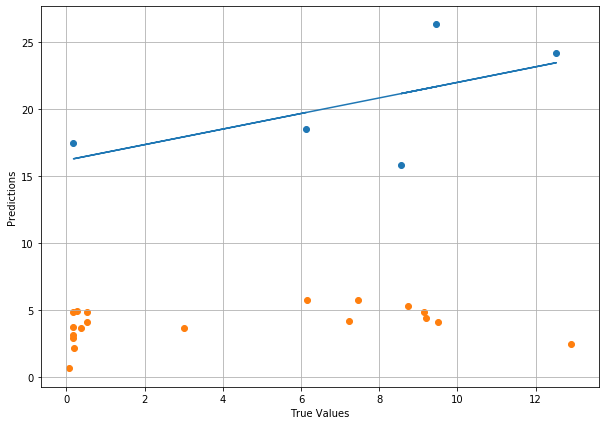

In [161]:
# Define PLS object
pls = PLSRegression(n_components=2)
# Fit
pls.fit(Xm_train, y_train)

y_pred = pls.predict(Xm_test)
y_pred1 = pls.predict(Xm_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Savgol filter

In [80]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(19, 1446) (19, 1)
(5, 1446) (5, 1)


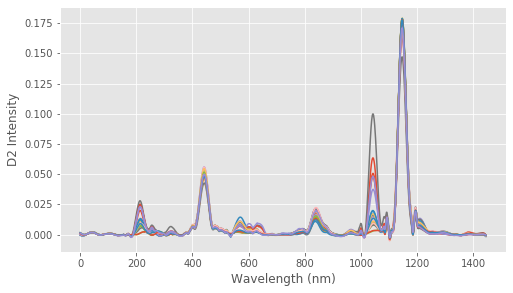

100% completed
Suggested number of components:  3



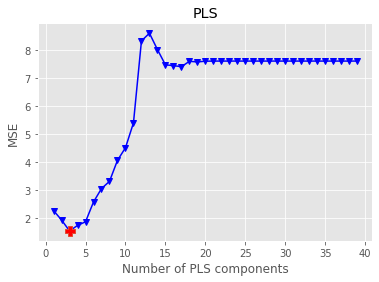

R2 calib: 0.476
R2 CV: -0.131
MSE calib: 0.716
MSE CV: 1.544


In [81]:
# Calculate second derivative
X2 = savgol_filter(x_df, 101, polyorder = 6,deriv=0) # Is this useful with LIBS spectra???
# Plot second derivative
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(range(len(X2.T)), X2.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Intensity')
    plt.show()
    
    
X2_1 = msc(X2)[0]
    
optimise_pls_cv(X2_1, y_df, 40, plot_components=True)

100% completed
Suggested number of components:  2



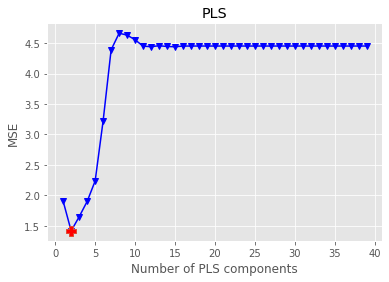

R2 calib: 0.620
R2 CV: -0.120
MSE calib: 0.481
MSE CV: 1.417


In [86]:
X2_train = savgol_filter(X_train, 37, polyorder = 4,deriv=1) 
X2_test = savgol_filter(X_test, 35, polyorder = 4,deriv=1) 




optimise_pls_cv(X2_train, y_train, 40, plot_components=True)

R2_pred:  -0.4142851041406448
R2_cv:  -0.502517109222492

[real, predictions]
[[ 0.339      -0.72308828]
 [ 3.57        0.70202523]
 [ 0.2         0.71243987]
 [ 0.293       1.80524588]
 [ 0.363      -0.11310216]]


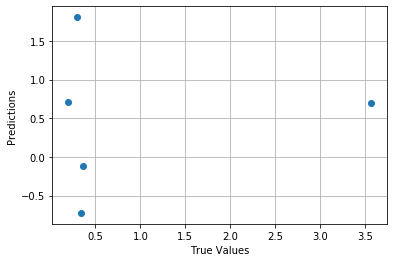

In [87]:
# Define PLS object
pls = PLSRegression(n_components=4)
# Fit
pls.fit(X2_train, y_train)

y_pred = pls.predict(X2_test)

# Cross-validation
y_cv = cross_val_predict(pls, X2_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Elastic Net

In [191]:
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.15)

alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

In [192]:
for a in alphas:
    model = ElasticNet(alpha=a).fit(X_train,y_train)   
    score = model.score(X_train, y_train)
    pred_y = model.predict(X_test)
    mse = mean_squared_error(y_test, pred_y)   
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))

Alpha:0.0001, R2:0.25, MSE:62.13, RMSE:7.88
Alpha:0.0010, R2:0.23, MSE:61.51, RMSE:7.84
Alpha:0.0100, R2:0.19, MSE:56.31, RMSE:7.50
Alpha:0.1000, R2:0.01, MSE:48.34, RMSE:6.95
Alpha:0.3000, R2:0.00, MSE:48.04, RMSE:6.93
Alpha:0.5000, R2:0.00, MSE:48.04, RMSE:6.93
Alpha:0.7000, R2:0.00, MSE:48.04, RMSE:6.93
Alpha:1.0000, R2:0.00, MSE:48.04, RMSE:6.93


Train score:  0.25262943237603186
RMSE:  7.882376541340004
R^2:  -1.3626504752621091 



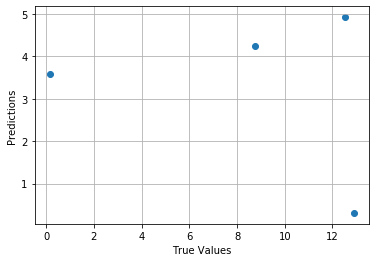

In [193]:
model = ElasticNet(alpha=0.0001).fit(X_train,y_train)   
score = model.score(X_train, y_train)
print("Train score: ", score)
pred_y = model.predict(X_test)


rmse = sqrt(mean_squared_error(y_test, pred_y))
r2 = r2_score(y_test, pred_y)
print("RMSE: ", rmse)
print("R^2: ", r2, "\n")

plt.scatter(y_test, pred_y)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Random Forest

In [181]:
#X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.15)
#X_train, X_test, y_train, y_test = train_test_split(principalComponents, y_df, test_size=0.15)

X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.15)


print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(y_test)

(20, 92) (20, 1)
(4, 92) (4, 1)


In [182]:
y_test=np.ravel(y_test)
print(y_test.shape)
y_train=np.ravel(y_train)
print(y_train.shape)

(4,)
(20,)


RMSE:  3.175766780558788
R^2:  0.233803603610093 

[real, predictions]
[[8.565    3.207436]
 [9.46     6.27132 ]
 [6.16     6.568392]
 [0.16     1.301938]]


Text(0, 0.5, 'Predictions')

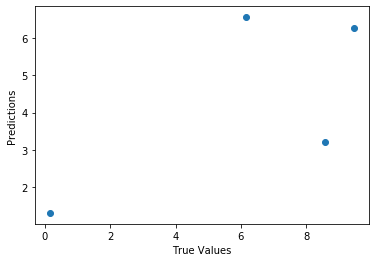

In [183]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 2500, max_depth=30, random_state = 42)
# Train the model on training data

rf.fit(X_train, y_train);

# Use the forest's predict method on the test data
predictions = rf.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("RMSE: ", rmse)
print("R^2: ", r2, "\n")

y_test= y_test.reshape((len(y_test), 1))
predictions=predictions.reshape((len(y_test), 1))
#print((y_test, predictions))

b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

# MultiOutput Random Forest

In [184]:
multi_y = concentration[:,1:-2]
print (multi_y.shape)
print (type(multi_y))
df_y= pd.DataFrame(multi_y)
print (type(df_y))
df_y

(24, 6)
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


,0,1,2,3,4,5
0,0.185,0.228,2.940,0.0304,0.0620,0.280
1,0.360,0.600,1.100,0.0700,0.2000,0.830
2,9.140,1.010,0.200,0.4200,3.6000,0.410
3,8.565,0.000,0.293,0.8870,2.6360,0.330
4,9.500,0.000,0.391,0.0000,0.0580,0.016
5,7.220,0.140,0.360,0.0840,0.1200,0.053
6,7.460,0.530,0.036,0.1400,0.1500,0.100
7,12.900,0.120,0.520,0.1550,0.5200,0.286
8,8.750,0.460,1.710,0.0290,2.0000,0.056
9,0.260,0.420,1.260,0.0200,0.0040,1.160


In [185]:
X_train, X_test, y_train, y_test = train_test_split(x_df, df_y, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(x_selecta, df_y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(19, 92) (19, 6)
(5, 92) (5, 6)


In [186]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=650,
                                                          max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=30,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=650,
                                                

In [187]:
y_multirf = regr_multirf.predict(X_test)

In [188]:
print(y_test.shape)
print(y_multirf.shape)

(5, 6)
(5, 6)


In [189]:
rmse = sqrt(mean_squared_error(y_test, y_multirf))
r2 = r2_score(y_test, y_multirf)

print("R^2: ", r2)
print("RMSE: ", rmse)

R^2:  -0.5915948311300147
RMSE:  2.983951951006331


In [86]:
b=np.append(np.around(y_test,3), np.around(y_multirf,3), axis=1)

print("[real, predictions]")
print(b)

[real, predictions]
[[9.190e+00 0.000e+00 3.390e-01 0.000e+00 6.000e-03 8.000e-03 6.377e+00
  3.570e-01 6.980e-01 5.550e-01 8.500e-01 3.210e-01]
 [6.160e+00 0.000e+00 3.630e-01 0.000e+00 6.000e-03 2.060e-01 6.750e+00
  6.030e-01 7.110e-01 1.047e+00 2.255e+00 2.480e-01]
 [1.253e+01 3.100e-01 2.500e-02 5.000e-02 5.600e-02 3.300e-02 7.030e+00
  4.610e-01 1.025e+00 6.500e-01 1.081e+00 3.820e-01]
 [7.460e+00 5.300e-01 3.600e-02 1.400e-01 1.500e-01 1.000e-01 5.601e+00
  5.800e-01 1.208e+00 8.240e-01 1.008e+00 4.250e-01]
 [1.800e-01 2.050e-01 2.480e+00 5.440e+00 1.600e+00 7.900e-02 6.232e+00
  2.480e-01 1.502e+00 4.060e-01 3.150e-01 2.910e-01]]


Text(0, 0.5, 'Predictions')

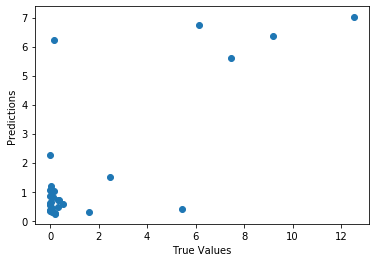

In [87]:
plt.scatter(y_test, y_multirf)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [88]:
y_pred=np.around(y_multirf,2)
y_pred[:,0]

array([6.38, 6.75, 7.03, 5.6 , 6.23])

In [89]:
y_test[0].values

array([ 9.19,  6.16, 12.53,  7.46,  0.18])

In [90]:
print("real: ", y_test[0].values)
print("pred: ", y_pred[:,0])

real:  [ 9.19  6.16 12.53  7.46  0.18]
pred:  [6.38 6.75 7.03 5.6  6.23]


# PLS-2

75% completed
Suggested number of components:  1



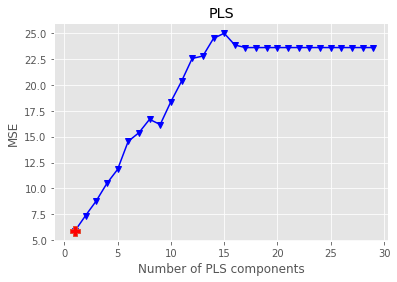

R2 calib: 0.021
R2 CV: -0.278
MSE calib: 4.524
MSE CV: 5.897


In [97]:
optimise_pls_cv(X_train, y_train, 30, plot_components=True)

In [102]:
# Define PLS object
pls = PLSRegression(n_components= 36)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ",score_pred) #NAMMERDA
print(score_cv)

R2_pred:  -1100.8235516358939
-2.8824700271329498


In [103]:
pd.DataFrame(np.round(y_pred, decimals=2))

,0,1,2,3,4,5
0,17.57,0.59,-0.99,-6.12,2.73,-0.87
1,-5.79,-0.19,3.31,5.81,0.02,0.86
2,-18.74,-0.21,8.28,15.60,-3.82,0.97
3,-44.40,-0.38,12.78,14.21,-3.86,1.40
4,-4.29,0.09,6.43,9.73,-0.53,0.69


In [104]:
np.round(y_test, decimals=2)

,0,1,2,3,4,5
2,9.14,1.01,0.20,0.42,3.60,0.41
5,7.22,0.14,0.36,0.08,0.12,0.05
10,0.07,0.10,0.41,0.18,0.06,1.45
11,0.16,0.31,0.88,0.10,0.11,1.14
9,0.26,0.42,1.26,0.02,0.00,1.16
